# 2022-01-08 • Big-N-to-1 simulation

In [1]:
#

In [2]:
include("nb_init.jl")

[ Info: Pkg.resolve()
[ Info: using Revise
[ Info: import Distributions
[ Info: import PyPlot
[ Info: import DataFrames, PrettyTables
[ Info: import MyToolbox
[ Info: using VoltageToMap


In [17]:
using Unitful: pA, pF, nS
# @withfeedback using OrdinaryDiffEq
using Parameters, ComponentArrays

@alias CArray = ComponentArray;

In [18]:
save(fname) = savefig(fname, subdir="methods");

## Parameters

In [19]:
sim_duration = 10 * seconds
Δt = 0.1 * ms;

### Input spikers

In [20]:
N_unconn = 100
N_exc    = 5200
N_inh    = N_exc ÷ 4

1300

In [21]:
N_conn = N_inh + N_exc

6500

In [22]:
N = N_conn + N_unconn

6600

In [23]:
input_spike_rate = LogNormal_with_mean(4Hz, √0.6)  # See the previous notebook

LogNormal{Float64, Unitful.FreeUnits{(Hz,), 𝐓^-1, nothing}}(μ=1.0862943611198905, σ=0.7745966692414834)

### Synapses

Reversal potential at excitatory and inhibitory synapses,  
as in the report [`2021-11-11__synaptic_conductance_ratio.pdf`](https://github.com/tfiers/phd-thesis/blob/main/reports/2021-11-11__synaptic_conductance_ratio.pdf):

In [26]:
v_exc =   0 * mV
v_inh = -65 * mV;

Exponential decay time constant of synaptic conductance `g`, $τ_{s}$ (`s` for "synaptic"):

In [27]:
τs =   7 * ms;

### Izhikevich neuron

Membrane potential `v` and adaptation variable `u` at `t = 0`:

In [28]:
v0    = -80 * mV
u0    =   0 * pA;

Parameters for a cortical regular spiking neuron:

In [29]:
@with_kw struct IzhikevichParams
    C      = 100 * pF
    k      = 0.7 * (nS/mV)
    b      = -2 * nS
    v_r    = -60 * mV
    v_t    = -40 * mV
    v_peak =  35 * mV
    c      = -50 * mV
    a      = 0.03 / ms
    d      = 100 * pA
end

cortical_RS = IzhikevichParams();

## Neuron IDs

In [30]:
neuron_ids = CArray(exc = 1:N_exc, inh = 1:N_inh, unconn = 1:N_unconn)

ComponentVector{Int64}(exc = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  5191, 5192, 5193, 5194, 5195, 5196, 5197, 5198, 5199, 5200], inh = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300], unconn = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  91, 92, 93, 94, 95, 96, 97, 98, 99, 100])

In [31]:
only(getaxes(neuron_ids))

Axis(exc = 1:5200, inh = 5201:6500, unconn = 6501:6600)

In [32]:
showsome(labels(neuron_ids))

6600-element Vector{String}:
    1: "exc[1]"
    2: "exc[2]"
    ⋮
 2222: "exc[2222]"
    ⋮
 3423: "exc[3423]"
    ⋮
 6599: "unconn[99]"
 6600: "unconn[100]"


i.e. a neuron's **global** ID = its index into the [ComponentVector](https://github.com/jonniedie/ComponentArrays.jl) "`neuron_ids`".

## Inputs

In [35]:
λ = rand(input_spike_rate, N)  # sample firing rates, one for every input neuron
β = (1 ./ λ) .|> seconds       # alternative Exp parametrisation: scale (= 1 / rate)
ISI_distributions = Exponential.(β);
#   This uses julia's broadcasting `.` syntax: make an `Expontential` distribution for every value in the β vector

In [25]:
# Create v_syn vector: for each neuron, the reversal potential at its downstream synapses.
vs = CArray(E=fill(v_E, N_E), I=fill(v_I, N_I))

ComponentVector{Quantity{Int64, 𝐋^2 𝐌 𝐈^-1 𝐓^-3, Unitful.FreeUnits{(mV,), 𝐋^2 𝐌 𝐈^-1 𝐓^-3, nothing}}}(E = Quantity{Int64, 𝐋^2 𝐌 𝐈^-1 𝐓^-3, Unitful.FreeUnits{(mV,), 𝐋^2 𝐌 𝐈^-1 𝐓^-3, nothing}}[0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV  …  0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV], I = Quantity{Int64, 𝐋^2 𝐌 𝐈^-1 𝐓^-3, Unitful.FreeUnits{(mV,), 𝐋^2 𝐌 𝐈^-1 𝐓^-3, nothing}}[-65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV  …  -65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV])

In [26]:
print("""
ComponentVector{typeof(Quantity(::Int64, mV))}(E = Quantity(::Int64, mV)[0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV  …  0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV], I = Quantity(::Int64, mV)[-65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV  …  -65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV])
""")

ComponentVector{typeof(Quantity(::Int64, mV))}(E = Quantity(::Int64, mV)[0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV  …  0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV, 0 mV], I = Quantity(::Int64, mV)[-65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV  …  -65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV, -65 mV])


In [27]:
CArray(E=fill(0,N_E), I=fill(-65,N_I))

ComponentVector{Int64}(E = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], I = [-65, -65, -65, -65, -65, -65, -65, -65, -65, -65  …  -65, -65, -65, -65, -65, -65, -65, -65, -65, -65])

In [36]:
print("""
ComponentVector{::Quantity(::Int64, mV)}(E = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], I = [-65, -65, -65, -65, -65, -65, -65, -65, -65, -65  …  -65, -65, -65, -65, -65, -65, -65, -65, -65, -65])
""")

ComponentVector{::Quantity(::Int64, mV)}(E = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], I = [-65, -65, -65, -65, -65, -65, -65, -65, -65, -65  …  -65, -65, -65, -65, -65, -65, -65, -65, -65, -65])


In [37]:
print("""
ComponentVector{Quantity{Int64, mV}}(E = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], I = [-65, -65, -65, -65, -65, -65, -65, -65, -65, -65  …  -65, -65, -65, -65, -65, -65, -65, -65, -65, -65])
""")

ComponentVector{Quantity{Int64, mV}}(E = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0], I = [-65, -65, -65, -65, -65, -65, -65, -65, -65, -65  …  -65, -65, -65, -65, -65, -65, -65, -65, -65, -65])


This is the expected type interface.
But they add those ..
oh no, I can feel it coming. I'm about to make my own unit library innit.
aargh. fucik. lol.
ok uhm. no.
we're gonna go unitless again.
hahahahahahah

In [33]:
vs[1]

0 mV

In [34]:
typeof(vs[1])

Quantity{Int64, 𝐋^2 𝐌 𝐈^-1 𝐓^-3, Unitful.FreeUnits{(mV,), 𝐋^2 𝐌 𝐈^-1 𝐓^-3, nothing}}

## Sim

Proof of concept of spike generation using a priority queue.

In [13]:
using DataStructures
using Unitful: Time

first_spiketimes = rand.(ISI_distributions)

pq = PriorityQueue{Int, Time}()
for (input_neuron, t) in enumerate(first_spiketimes)
    enqueue!(pq, input_neuron => t)
end

t = 0s
while t < sim_duration
    input_neuron, t = dequeue_pair!(pq)  # earliest spike
    new_ISI = rand(ISI_distributions[input_neuron])
    enqueue!(pq, input_neuron => t + new_ISI)
end

Superfast.

In [50]:
function f(D, vars, params, t)
    @unpack C, k, b, v_r, v_t, v_peak, c, a, d = params
    @unpack v, u = vars
    D.v = (k * (v - v_r) * (v - v_t) - u) / C
    D.u = a * (b * (v - v_r) - u)
    D.g = -g / τ_syn
    return nothing
end

x0 = ComponentArray{Quantity{Float64}}(v = v0, u = u0)  # note eltype cast to float
prob = ODEProblem(f, x0, float(sim_duration), cortical_RS)
# integrator = init(prob, Tsit5(); Δt, adaptive=true)

ODEProblem with uType ComponentVector{Quantity{Float64}, Vector{Quantity{Float64}}, Tuple{Axis{(v = 1, u = 2)}}} and tType Quantity{Float64, 𝐓, Unitful.FreeUnits{(s,), 𝐓, nothing}}. In-place: true
timespan: (0.0 s, 10.0 s)
u0: ComponentVector{Quantity{Float64}}(v = -80.0 mV, u = 0.0 pA)

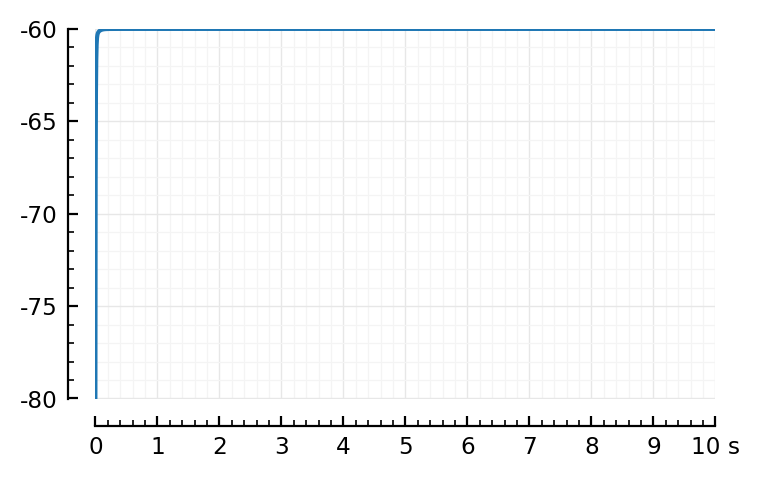

In [617]:
t = 0ms:0.1ms:sim_duration
v = t -> sol(t).v / mV |> NoUnits
plot(t, v.(t));

In [51]:
x0

ComponentVector{Quantity{Float64}}(v = -80.0 mV, u = 0.0 pA)

In [48]:
ca = ComponentArray{Quantity{Float64}}(v=v0, u=u0)

ComponentVector{Quantity{Float64}}(v = -80.0 mV, u = 0.0 pA)

In [34]:
x0

ComponentVector{Quantity{Float64}}(v = -80.0 mV, u = 0.0 pA)

In [ ]:
function Base.float(ca::ComponentArray)
    for